In [1]:
from nn_hmc_3d import NN_HMC
import dill
import numpy as np
import IPython
import jax.random as random
import jax.numpy as jnp
import matplotlib
import matplotlib.pyplot as plt
import h5py
from igm_emulator.emulator.plotVis import v_bins
from igm_emulator.emulator.emulator_run import nn_emulator
import os
'''
load model and auto-corr
'''
redshift = 5.4

# get the appropriate string and pathlength for chosen redshift
zs = np.array([5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.0])
z_idx = np.argmin(np.abs(zs - redshift))
z_strings = ['z54', 'z55', 'z56', 'z57', 'z58', 'z59', 'z6']
z_string = z_strings[z_idx]
in_path_hdf5 = '/home/zhenyujin/igm_emulator/igm_emulator/emulator/best_params/'
f = h5py.File(in_path_hdf5 + f'z{redshift}_nn_savefile.hdf5', 'r')
emu_name = f'{z_string}_best_param_training_768.p'
#IPython.embed()

best_params = dill.load(open(in_path_hdf5 + emu_name, 'rb'))
meanX = np.asarray(f['data']['meanX'])
stdX = np.asarray(f['data']['stdX'])
meanY = np.asarray(f['data']['meanY'])
stdY =  np.asarray(f['data']['stdY'])
print(meanX)
#best_params = load(f)
#print(f['performance']['residuals'])
#print(f['best_params']['custom_linear/~/linear_0']['w'])
#print(load(f'/home/zhenyujin/igm_emulator/igm_emulator/emulator/best_params/z{redshift}_nn_savefile.hdf5'))

in_path = f'/mnt/quasar2/mawolfson/correlation_funct/temp_gamma/final/{z_string}/final_135/'
n_paths = np.array([17, 16, 16, 15, 15, 15, 14])
n_path = n_paths[z_idx]
vbins = v_bins
param_in_path = '/mnt/quasar2/mawolfson/correlation_funct/temp_gamma/final/'
param_dict = dill.load(open(param_in_path + f'{z_string}_params.p', 'rb'))

fobs = param_dict['fobs']  # average observed flux <F> ~ Gamma_HI
log_T0s = param_dict['log_T0s']  # log(T_0) from temperature - density relation
T0s = np.exp(log_T0s)
gammas = param_dict['gammas']  # gamma from temperature - density relation

T0_idx = 11 #0-14
g_idx = 4 #0-8
f_idx = 7 #0-8

like_name = f'likelihood_dicts_R_30000_nf_9_T{T0_idx}_G{g_idx}_SNR0_F{f_idx}_ncovar_500000_P{n_path}_set_bins_4.p'
like_dict = dill.load(open(in_path + like_name, 'rb'))
theta_true = [fobs[f_idx], T0s[T0_idx], gammas[g_idx]]

Layers: [100, 100, 100, 276]
Activation: <function leaky_relu at 0x7fe0fe87de18>
L2 regularization lambda: 0.0001
meanX = [8.400e-02 9.149e+03 1.352e+00]
stdX = [1.36930639e-02 5.50374022e+03 6.02494813e-01]
train: (768, 3)
(358, 276)
[8.400e-02 9.149e+03 1.352e+00]


In [2]:
print(theta_true)

[0.099, 63.53569309711353, 1.3520000000000003]


In [3]:
theta=jnp.array([theta_true,theta_true,theta_true])
theta_i=theta.squeeze()
print(theta)
print(theta.shape)
print(theta_i.shape)

[[ 0.099     63.5356931  1.352    ]
 [ 0.099     63.5356931  1.352    ]
 [ 0.099     63.5356931  1.352    ]]
(3, 3)
(3, 3)


<class 'list'>


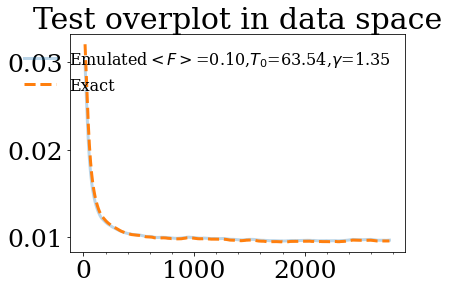

In [4]:
flux = like_dict['mean_data']
print(type(theta_true))

model = nn_emulator(best_params, theta_true)

fig2, axs2 = plt.subplots(1, 1)
axs2.plot(vbins, model, label=f'Emulated' r'$<F>$='f'{theta_true[0]:.2f},'
                                                     r'$T_0$='f'{theta_true[1]:.2f},'
                                                     r'$\gamma$='f'{theta_true[2]:.2f}', alpha=0.3)
axs2.plot(vbins, flux, label=f'Exact', linestyle='--')
plt.title('Test overplot in data space')
plt.legend()
plt.show()

In [5]:
    nn = NN_HMC(vbins,best_params,T0s,gammas,fobs,like_dict)
    key = random.PRNGKey(42)
    key, subkey = random.split(key)
    x_samples, samples, ln_probs, neff, neff_mean, \
    sec_per_neff, ms_per_step, r_hat, r_hat_mean, \
    hmc_num_steps, hmc_tree_depth, runtime = nn.mcmc_one(key, theta_true, flux)

true theta:[0.099, 63.53569309711353, 1.3520000000000003]
true x:[1.94591015e+00 2.00352811e+00 4.44089210e-16]
init pos:[[ 0.0988707  63.53564572  1.35190102]
 [ 0.09902056 63.53564321  1.35197072]
 [ 0.09900897 63.53581653  1.35206444]]


sample: 100%|██████████| 2000/2000 [05:51<00:00,  5.69it/s]


*** SUMMARY FOR HMC ***
total_time = 356.6064944267273 seconds for the HMC
total_steps = 59911 total steps
ms_per_step = 5.952270775429008 ms per step of the HMC
n_eff_mean = 1593.6666666666667 effective sample size, compared to ntot = 3000 total samples.
sec_per_neff = 0.224 seconds per effective sample
r_hat_mean = 1.0
max_tree_depth encountered = 10 in chain
There were 38 transitions that exceeded the max_tree_depth = 10
*************************


In [12]:
nn.plot_HMC(x_samples,samples,theta_true,"jit_2000_3_vec")

TypeError: 'NoneType' object is not subscriptable

In [6]:
import sys
sys.path.append('/home/zhenyujin/dw_inference/dw_inference/inference')
from utils import walker_plot, corner_plot

In [11]:
out_prefix = '/home/zhenyujin/igm_emulator/igm_emulator/hmc/plots/'
var_label = ['fobs', 'T0s', 'gammas']
cornerfile = out_prefix + '_corner_' + "jit_2000_3" + '.pdf'
corner_plot(samples, var_label,
            theta_true=jnp.asarray(theta_true),
            cornerfile=cornerfile)

TypeError: 'NoneType' object is not subscriptable

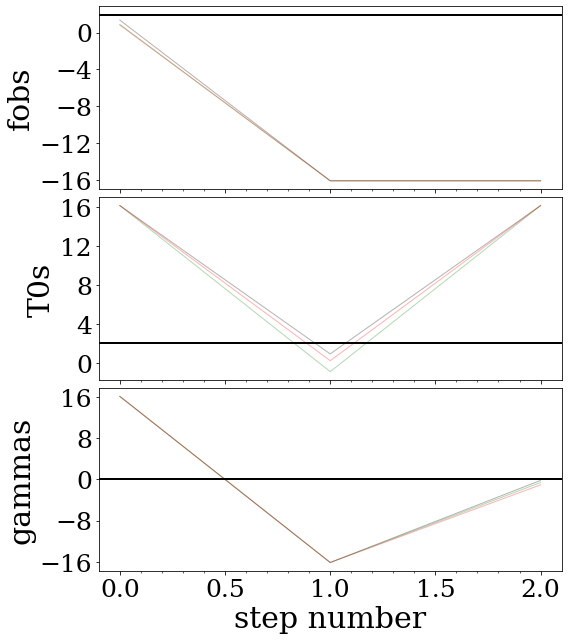

DeviceArray([[[  1.3590285 ,  16.11809555,  16.11809555],
              [  0.82084781,  16.11809555,  16.11809555],
              [  0.88093313,  16.11809555,  16.11809555]],

             [[-16.11809555,   0.91873401, -16.11809555],
              [-16.11809555,  -0.89745876, -16.11809555],
              [-16.11809555,   0.22553004, -16.11809555]],

             [[-16.11809555,  16.11809555,  -0.18516153],
              [-16.11809555,  16.11809555,  -0.59335468],
              [-16.11809555,  16.11809555,  -1.04927153]]], dtype=float64)

In [13]:
walkerfile = out_prefix + '_walkers_' + "jit_2000_3" + '.pdf'
walker_plot(np.swapaxes(jnp.asarray(x_samples), 0, 1), var_label,
                    truths= nn.theta_to_x(theta_true),
                    linewidth=1.0)
np.swapaxes(jnp.asarray(x_samples), 0, 1)